# Health Monitoring - Items Population

This notebook provides comprehensive monitoring to understand the item population over time. It includes:

1. Number of products over time
2. Distribution of sales over time including percentiles and standard deviation

## 1. Setup & Configuration

Import required libraries and set up parameters.

In [9]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ks_2samp
import ruptures as rpt
import sys
import os

# --- Imports from project root ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.clients.bigquery import BigQueryClient

# --- Plotting style ---
sns.set(style='whitegrid', context='notebook')

In [16]:
# --- Load Data From BigQuery ---
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
"""


# Extract data
df = bq_client.load_from_query(sales_query)

# Define target name to analyze:
target_name = "tgt_monthly_sales"

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 132934 rows from custom query.


## 2. Data Quality Checks

In [17]:
# Check for missing values
missing_summary = df.isnull().sum()
print('Missing values per column:')
print(missing_summary)

# Check for duplicates at expected granularity
duplicates = df.duplicated(subset=['ctx_date_month', 'ctx_item_id', 'ctx_dept_id'])
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    print(f'Found {num_duplicates} duplicate records.')
else:
    print('No duplicate records found at the expected granularity.')

Missing values per column:
ctx_date_month                         0
ctx_cat_id                             0
ctx_dept_id                            0
ctx_item_id                            0
tgt_monthly_sales                      0
tgt_monthly_sales_sum_3_next_months    0
dtype: int64
No duplicate records found at the expected granularity.


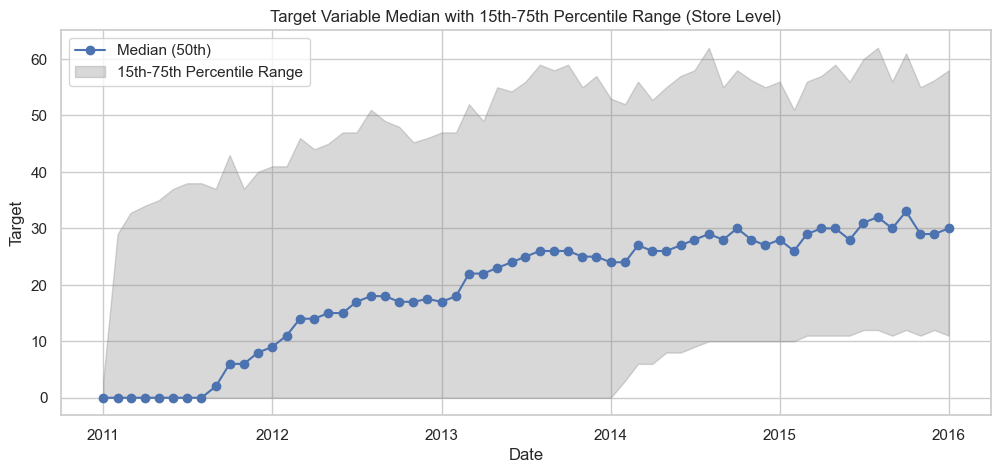

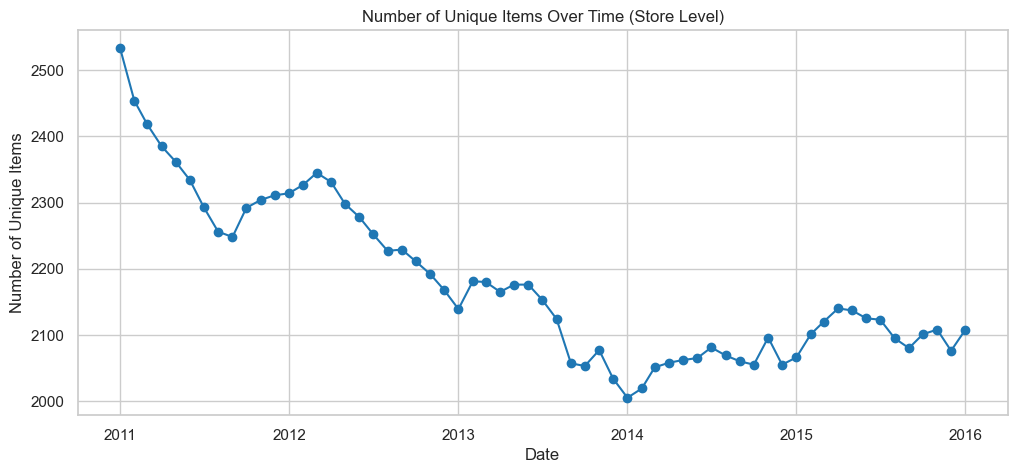

In [22]:
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()

# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

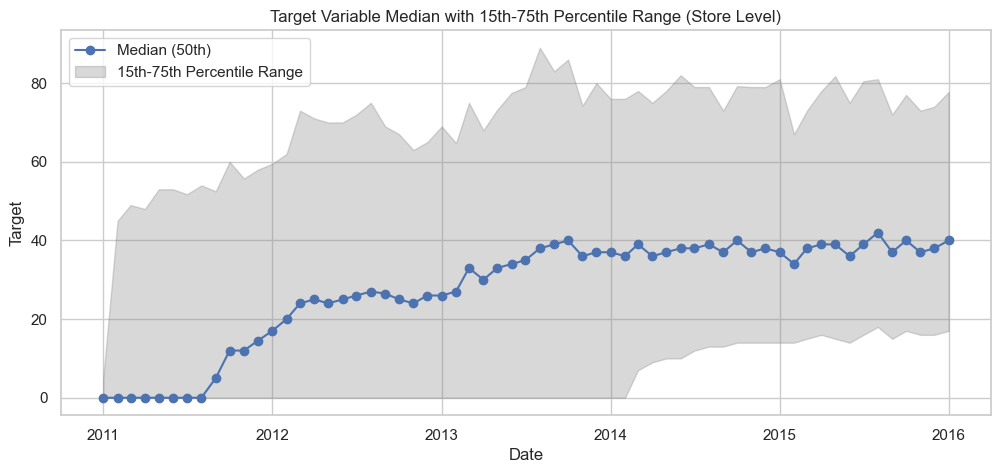

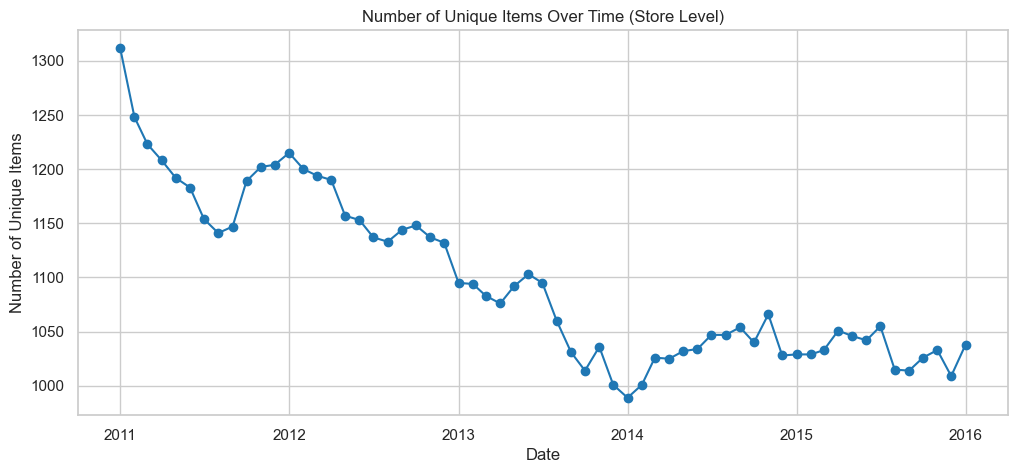

In [23]:
df_plot = df[df['ctx_cat_id'] == 'FOODS']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

# 01. Visualize per category

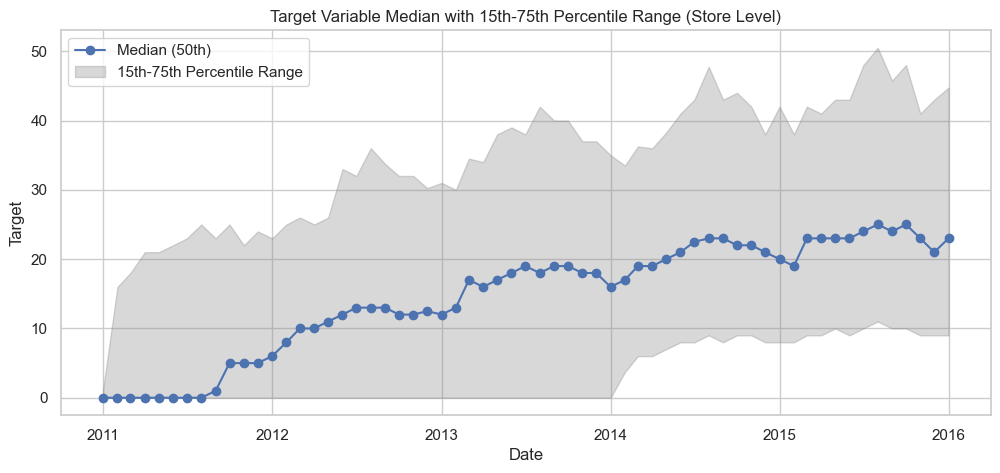

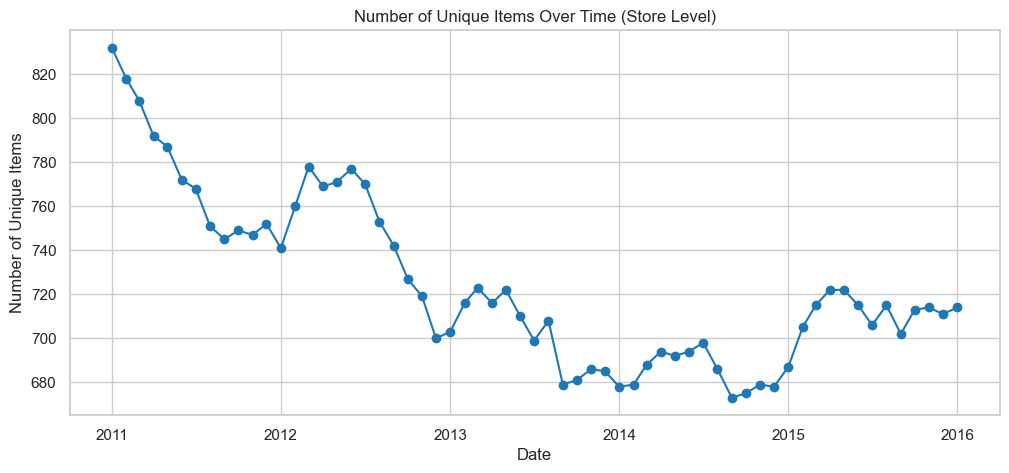

In [24]:
df_plot = df[df['ctx_cat_id'] == 'HOUSEHOLD']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

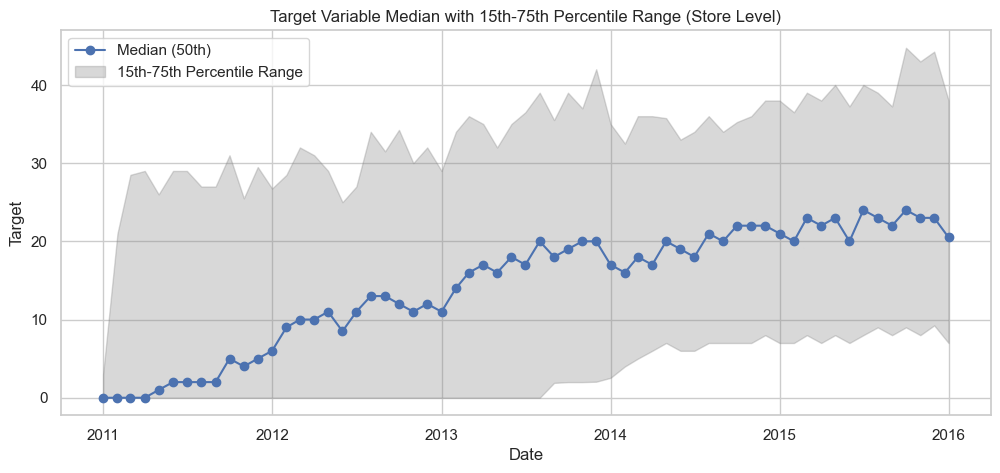

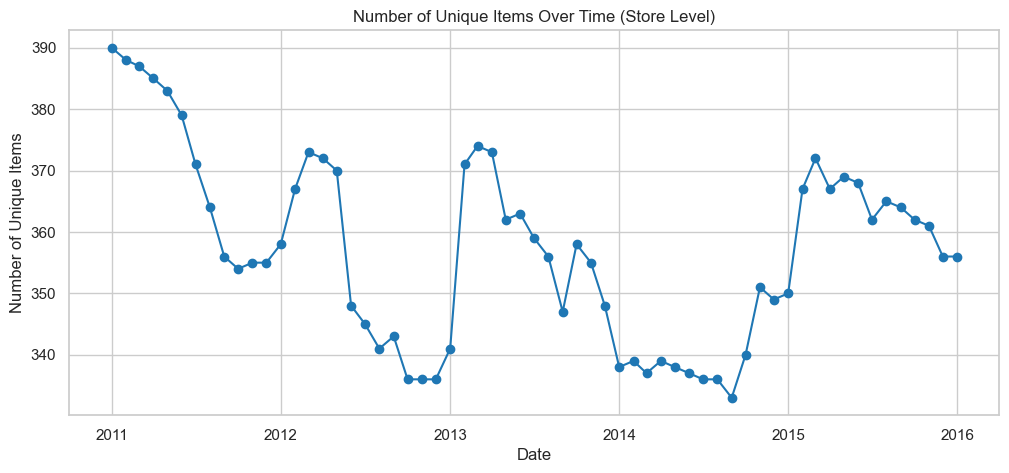

In [25]:
df_plot = df[df['ctx_cat_id'] == 'HOBBIES']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

# 0.2 Visualize per department

## 0.21 Foods

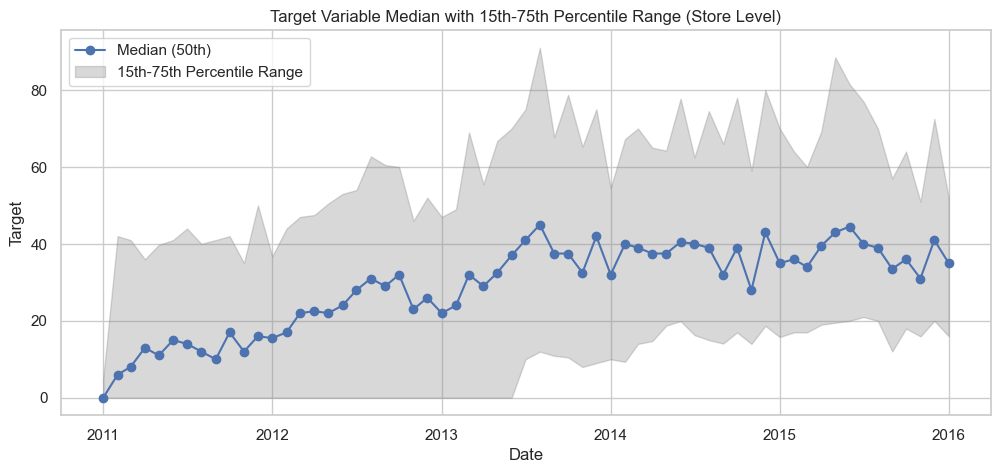

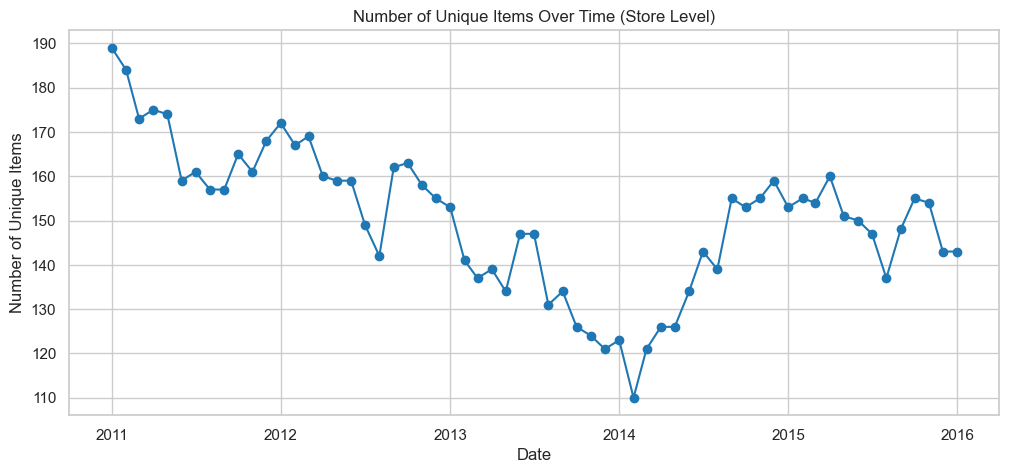

In [26]:
df_plot = df[df['ctx_dept_id'] == 'FOODS_1']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

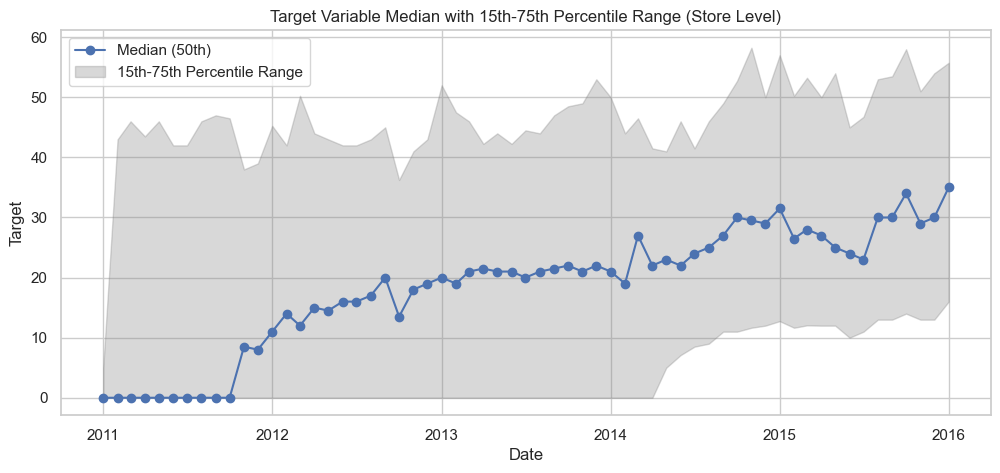

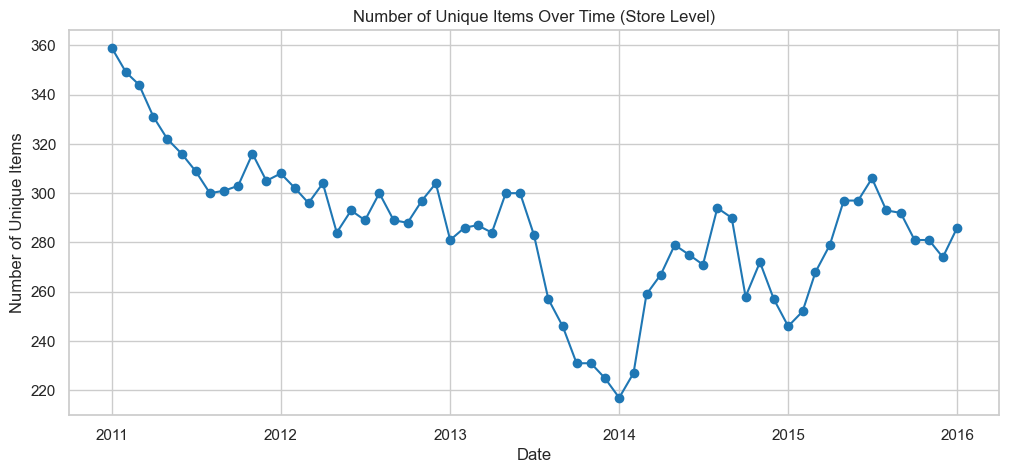

In [27]:
df_plot = df[df['ctx_dept_id'] == 'FOODS_2']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

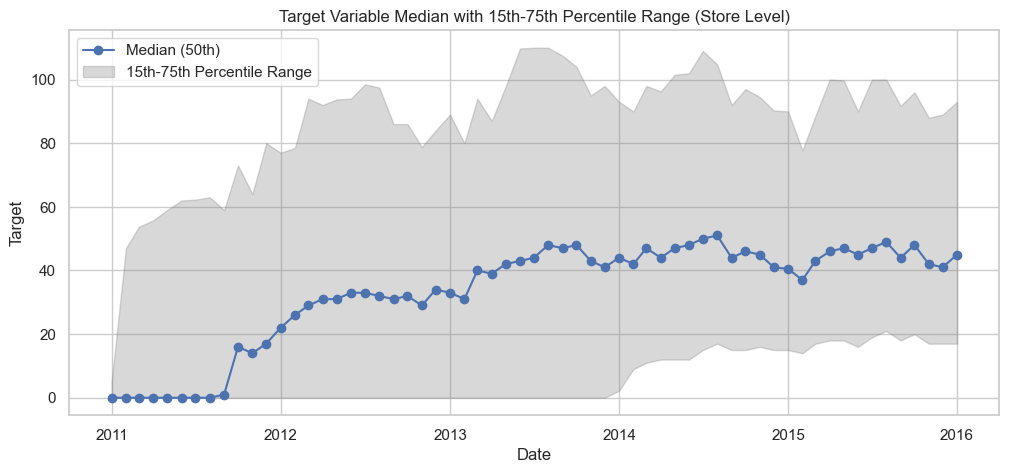

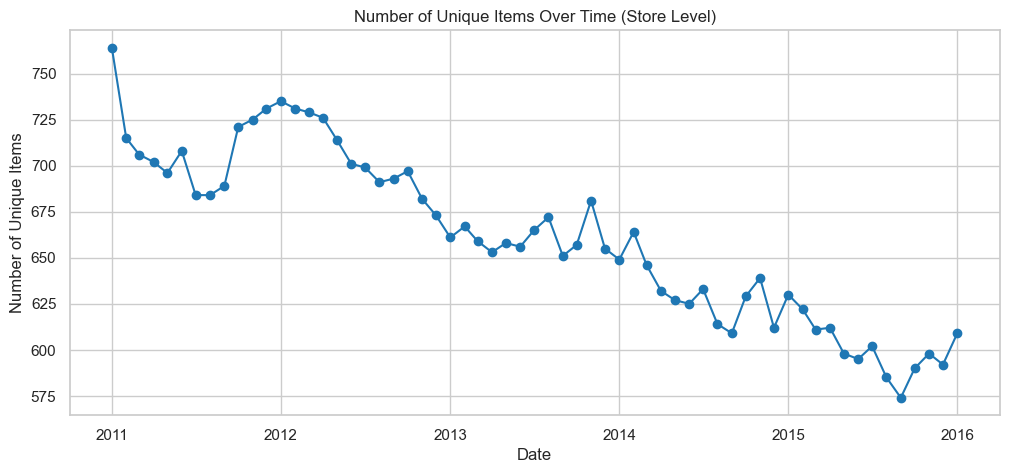

In [28]:
df_plot = df[df['ctx_dept_id'] == 'FOODS_3']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

## 0.22 Household

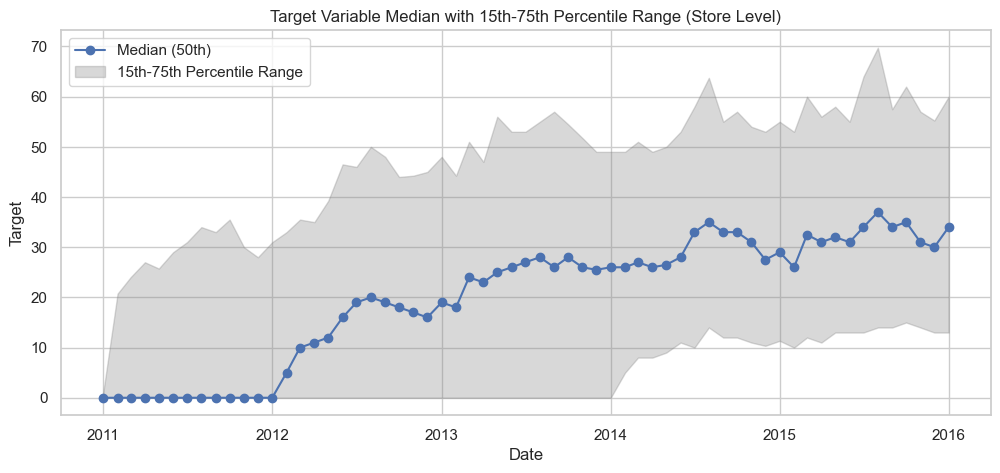

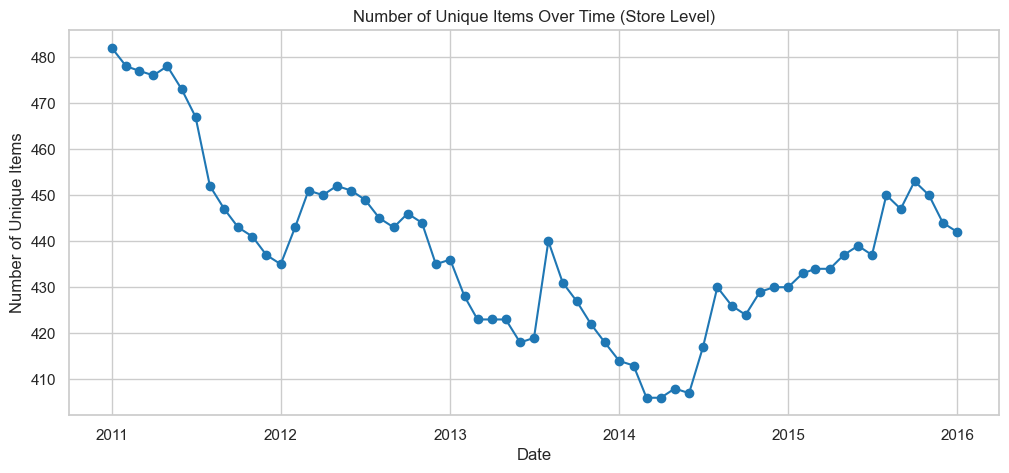

In [29]:
df_plot = df[df['ctx_dept_id'] == 'HOUSEHOLD_1']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

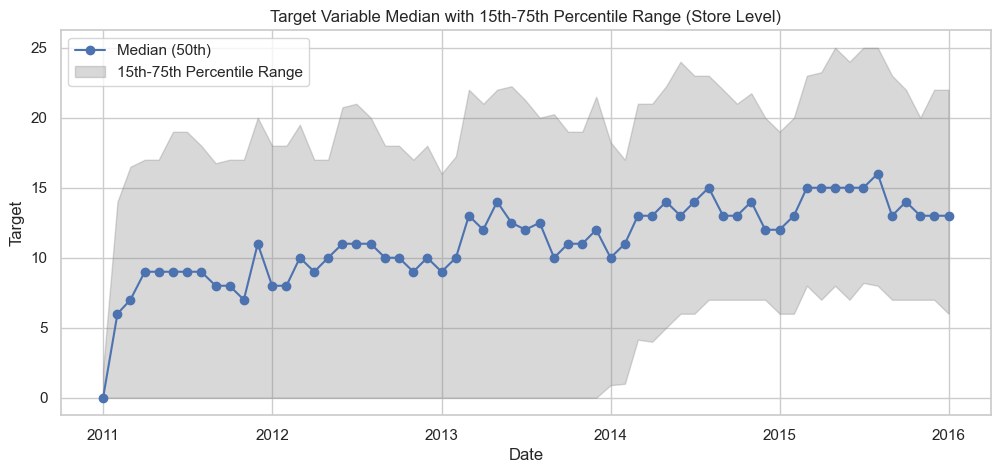

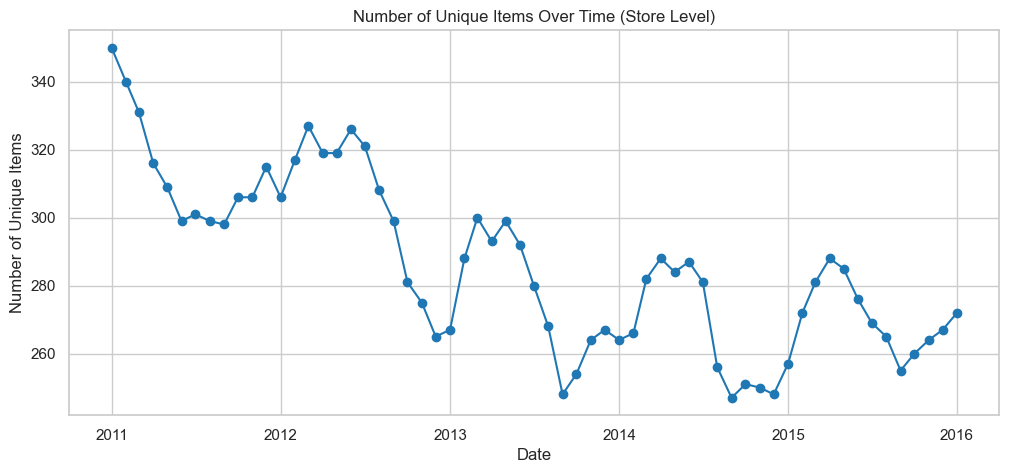

In [30]:
df_plot = df[df['ctx_dept_id'] == 'HOUSEHOLD_2']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

## 0.23 Hobbies

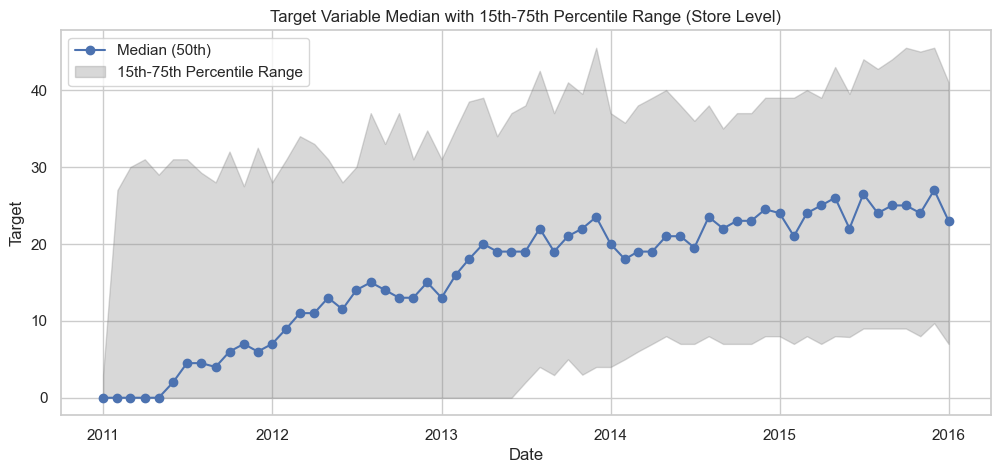

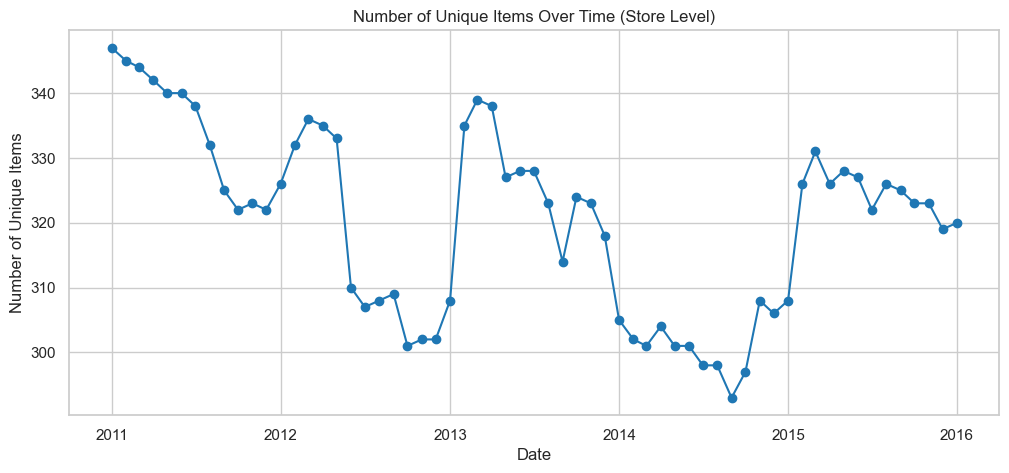

In [31]:
df_plot = df[df['ctx_dept_id'] == 'HOBBIES_1']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()

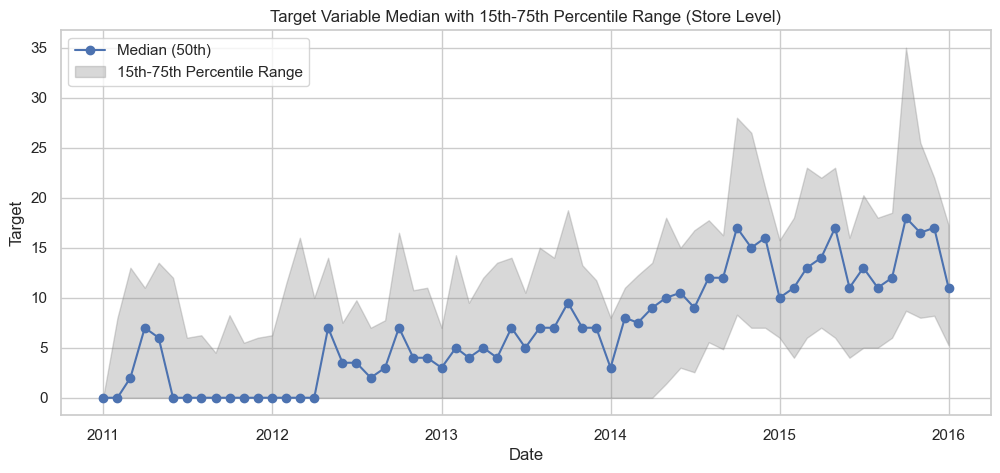

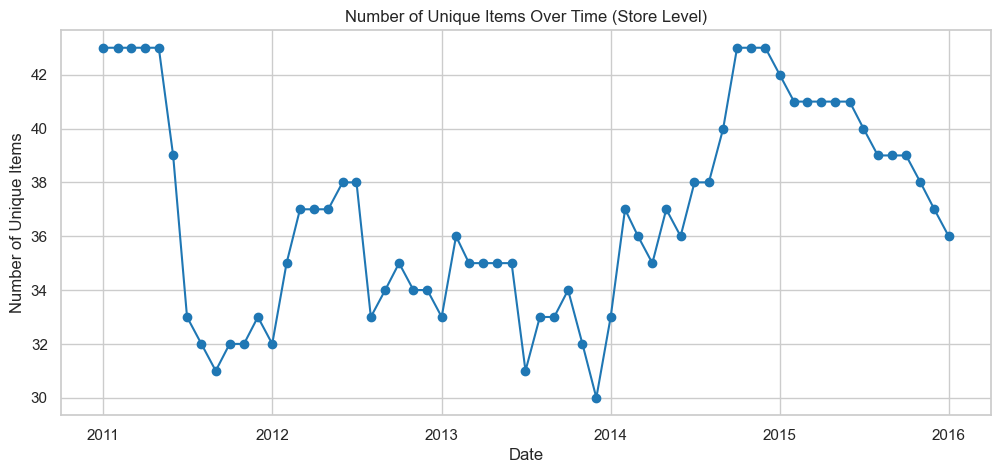

In [32]:
df_plot = df[df['ctx_dept_id'] == 'HOBBIES_2']
# Aggregate percentiles at store level (or by department/item as needed)
df_q15 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.15).sort_index()
df_q50 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.50).sort_index()
df_q75 = df_plot.groupby('ctx_date_month')[target_name].quantile(0.75).sort_index()
# Plot target variable percentiles over time with shadow
plt.figure(figsize=(12, 5))
plt.plot(df_q50.index, df_q50.values, marker='o', label='Median (50th)')
plt.fill_between(df_q50.index, df_q15.values, df_q75.values, color='gray', alpha=0.3, label='15th-75th Percentile Range')
plt.title('Target Variable Median with 15th-75th Percentile Range (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

num_items = df_plot.groupby('ctx_date_month')['ctx_item_id'].nunique().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(num_items.index, num_items.values, marker='o', color='tab:blue')
plt.title('Number of Unique Items Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Items')
plt.show()